In [1]:
from __future__ import print_function



In [2]:
"""DVS128 closed loop oscillator routine by Alexander Rivkind, Eldad Assa, Michael Kreiserman and Ehud Ahissar
based on: 
*DVS example by: Yuhuang Hu (duguyue100@gmail.com)
*"Syclop" paradigm: Ahissar and Assa 2016
"""
import numpy as np
import time
import SYCLOP_env as syc
import matplotlib.pyplot as plt


import pickle
from RL_brain_b import DeepQNetwork
import tensorflow as tf
import cv2
import copy
from misc import *
import maestro
import sys
import os
from pyaer.dvs128 import DVS128
%matplotlib notebook

In [3]:
subrate = 8

In [4]:
class localNetwork():
    def __init__(self, n_features, n_actions, lr=None, trainable = False):
        self.hp = HP()
        #self.default_nl=tf.nn.relu
        self.hp.lr = lr
        self.next_layer_id = 0
        self.n_features = n_features
        self.n_actions = n_actions
        self.theta = {}
        self.estimator = self.vanilla_network()
        self.q_target = tf.placeholder(tf.float32, [None, n_actions])
        if trainable:
            self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.q_target, logits=self.estimator)
            # self.loss = tf.reduce_mean(tf.losses.absolute_difference(self.q_target, self.estimator))
            # tf.losses.absolute_difference()
            # self.train_op = tf.train.GradientDescentOptimizer(self.hp.lr).minimize(self.loss)
            # self.train_op = tf.train.RMSPropOptimizer(self.hp.lr).minimize(self.loss)
            self.train_op = tf.train.AdamOptimizer(self.hp.lr).minimize(self.loss)
        self.sess = None

    def get_layer_id(self):
        this_layer_id = self.next_layer_id
        self.next_layer_id +=1
        return this_layer_id

#     def vanilla_network(self, layer_size = [None]+[200]*2+[ None]):
    def vanilla_network(self, layer_size = [None]+[81]*1+[ None]):
        layer_size[0] = self.n_features
        layer_size[-1] = self.n_actions
        next_l = self.input_layer() #todo currently the  number of features in the input layer is defined elsewhere
        self.observations = next_l
        for ll, ll_size  in enumerate(layer_size[1:-1]):
            next_l = self.dense_ff_layer(next_l, ll_size)
            next_l = tf.nn.dropout(next_l, 0.98)
        ll_size=layer_size[-1]
        next_l = self.dense_ff_layer(next_l, ll_size, nl= lambda x: x,g=1e-10)
        return next_l


    def dense_ff_layer(self, previous_layer, output_size, nl=tf.nn.relu, theta = None,g=1.0):
        if theta is None:
            this_theta = {}
            # print(np.float(np.shape(previous_layer)[-1])**0.5)
            this_theta['w'] = tf.Variable(
                tf.random_normal(shape=[np.shape(previous_layer)[-1].value, output_size],
                                 mean=0.0,
                                 stddev=g*2.0 / np.sqrt(np.shape(previous_layer)[-1].value)))
            this_theta['b'] = tf.Variable(
                tf.random_normal(shape=[1, output_size],
                                 mean=0.0,
                                 stddev=0.01))
        else:
            error('explicit theta is still unsupported')
        self.theta[self.get_layer_id()] = this_theta
        #print(self.get_layer_id())
        ff_layer = nl(tf.matmul(previous_layer, this_theta['w']) + this_theta['b'])
        return ff_layer

    def input_layer(self):
        return tf.placeholder(tf.float32, [None, self.n_features])

    # def train_step_op(self):
    #     return tf.train.RMSPropOptimizer(self.hp.lr).minimize(self.loss)

    def assign_param_prep(self,source_nwk): #todo support more elaborated structures than double dictionary
        self.assign_param_op = []
        for ll in source_nwk.theta.keys():
            for this_param in source_nwk.theta[ll]:
                self.assign_param_op.append(tf.assign(self.theta[ll][this_param],
                                                 source_nwk.theta[ll][this_param]))

    def theta_values(self): #todo support more elaborated structures than double dictionary
        t = {}
        for ll in self.theta.keys():
            t[ll] = {}
            for this_param in self.theta[ll]:
                t[ll][this_param] = self.theta[ll][this_param].eval(self.sess)
        return t

    def theta_update(self,t): #todo support more elaborated structures than double dictionary
        for ll in t.keys():
            for this_param in t[ll]:
                self.theta[ll][this_param].assign(t[ll][this_param]).op.run(session=self.sess)

    def update(self, sess):
        sess.run(self.assign_param_op)

In [ ]:
    def training_step(nwk, observations, q_target):
        return sess.run([nwk.train_op,nwk.loss],
                  feed_dict={nwk.observations: observations,
                             nwk.q_target: q_target})

    def calc_loss(nwk, observations, q_target):
        return sess.run([nwk.loss],
                  feed_dict={nwk.observations: observations,
                             nwk.q_target: q_target})
    
    def a_eval(nwk,observations):
        return sess.run(nwk.estimator,
                  feed_dict={nwk.observations: observations})

In [ ]:
class Free_run_agent():
    def __init__(self,max_q = None):
        self.hp = HP()
#         self.hp.action_space = ['v_right','v_left','v_up','v_down','null'] + \
#                                [['v_right','v_up'],['v_right','v_down'],['v_left','v_up'],['v_left','v_down']]#
        self.hp.action_space = ['v_right','v_left','null']
        self.hp.max_speed  = 10
        self.q_centre = np.array([0.,0.], dtype='f') 
        self.reset()

    def reset(self):
        self.q_ana = np.array([0.,0.], dtype='f') 
        self.qdot = np.array([0.0,0.0])
        self.qdotdot = np.array([0.0,0.0])
        self.q = np.int32(np.floor(self.q_ana))

    def sync_with_servo(self,servo,orientations = [0,1]):
        for orientation in orientations:
            if not servo.isMoving(orientation):
                self.qdot[orientation]=0.0
                
            
    def act(self,a):
        if a is None:
            action = 'null'
        else:
            action = self.hp.action_space[a]
        #delta_a = 0.001
        if type(action) == list:
            for subaction in action:
                self.parse_action(subaction)
        else:
            self.parse_action(action)

        #print('debug', self.max_q, self.q_centre)
        self.qdot += self.qdotdot
        #self.qdot -= self.hp.returning_force*(self.q_ana-self.q_centre)
        self.q_ana +=self.qdot
        self.q = np.int32(np.floor(self.q_ana))

    def parse_action(self,action):
        if type(action)==int:
            self.qdot[0] = action
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_up':   # up
            self.qdot[1] = self.qdot[1] + (1 if self.qdot[1] < self.hp.max_speed else 0)
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_down':   # down
            self.qdot[1] = self.qdot[1] - (1 if self.qdot[1] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_left':   # left
            self.qdot[0] = self.qdot[0] - (1 if self.qdot[0] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_right':   # right
            self.qdot[0] = self.qdot[0] + (1 if self.qdot[0] < self.hp.max_speed else 0) 
            self.qdotdot = np.array([0.,0.])
        elif action == 'null':   # null
            pass
        else:
            error('unknown action')

In [ ]:
import pickle

In [ ]:
hp = HP()
hp.mem_depth=1
hp.logmode = False
hp.steps_between_learnings = 100
hp.save_path = 'saved_runs'
hp.this_run_name = 'rateSpikeGames' + '_noname_' + str(int(time.time()))
hp.description = "work on copying cyclop into rates"
hp.mem_depth = 1
hp.max_episode =  10000
hp.steps_per_episode = 1000
hp.steps_between_learnings = 100
hp.fading_mem = 0.5
recorder_file = 'records.pkl'
hp_file = 'hp.pkl'
hp.contrast_range = [1.0,1.1]
hp.logmode = False
hp.dt_nom=0.025
#     recorder = Recorder(n=4)




if not os.path.exists(hp.save_path):
    os.makedirs(hp.save_path)

hp.this_run_path = hp.save_path+'/'+hp.this_run_name+'/'
if not os.path.exists(hp.this_run_path):
    os.makedirs(hp.this_run_path)
else:
    error('run name already exists!')


with open(hp.this_run_path+hp_file, 'wb') as f:
    pickle.dump(hp, f)

sensor = syc.Sensor()
agent = Free_run_agent()

reward = syc.Rewards()
observation_size = 256*4
# RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
#                   reward_decay=0.99,
#                   e_greedy=0.999,
#                   e_greedy0=0.999,
#                   replace_target_iter=10,
#                   memory_size=100000,
#                   e_greedy_increment=0.0001,
#                   learning_rate=0.0025,
#                   double_q=False,
#                   dqn_mode=True,
#                   state_table=np.zeros([1,observation_size*hp.mem_depth])
#                   )
# #     RL.dqn.load_nwk_param('saved_runs/run_syclop_lirondb.py_noname_1557658952/best_liron.nwk')
# #     RL.dqn.load_nwk_param('zhoka.nwk')
# #     RL.dqn.load_nwk_param('saved_runs/old_flat_saves/liron_random_ic05.nwk')#   
# RL.dqn.load_nwk_param('Telluride_candidate1.nwk')

network = localNetwork( 128, 3, lr=0.0025, trainable = True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# with open('nwk200x200xrelu_0p1_d0p5.nwk', 'rb') as f:
# with open('nwk200x200xrelu_0p1_d0p5.nwk', 'rb') as f:
with open('nwk81xrelu_0p1_in128.nwk', 'rb') as f:
    with sess.as_default():
        theta_list = pickle.load(f)
        network.theta_update(theta_list)

In [ ]:

def subsample(data,s):
    sub=list(range(0,len(data[0]),s))
    return [dd[sub] for dd in data]

In [ ]:
servo = maestro.Controller(ttyStr='/dev/ttyACM1')

In [ ]:
def gohome():    
    servo.setSpeed(0,0)
    servo.setSpeed(1,0)
    servo.setTarget(1,7500)     #set speed of servo 1
    servo.setTarget(0,5000)  #set servo to move to center position
    servo.setSpeed(0,1)
    servo.setSpeed(1,1)
    time.sleep(1.0)

In [ ]:
gohome()

In [ ]:
# servo.moveByVelocity(0,-10)

In [ ]:
def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/1.0
    return subsample([normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])],subrate)[0]

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5
recorder = Recorder(n=7)

In [ ]:
    with open(hp.this_run_path+hp_file, 'wb') as f:
        pickle.dump(hp, f)

going home!
step 0
0 1000  running reward    0.03400660642832314
going home!
step 1000
1 2000  running reward    0.08745915474935605
going home!
step 2000
2 3000  running reward    0.1845395649771667
going home!
step 3000
3 4000  running reward    0.0729902248332642
going home!
step 4000
4 5000  running reward    0.027776708527099774
going home!
step 5000
5 6000  running reward    0.010738055561663733
going home!
step 6000
6 7000  running reward    0.005035449599627047
going home!
step 7000
7 8000  running reward    0.0020663803243271
going home!
step 8000
8 9000  running reward    0.0016878353225491523
going home!
step 9000


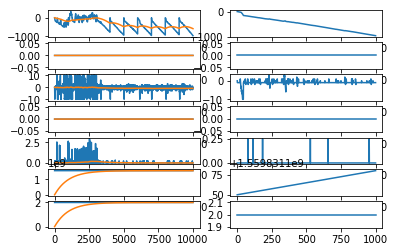

9 10000  running reward    0.0015057197232485173
going home!
step 10000
10 11000  running reward    0.0014642109949169577
going home!
step 11000
11 12000  running reward    0.0011908125472894521
going home!
step 12000
12 13000  running reward    0.0009748213190747194
going home!
step 13000
13 14000  running reward    0.0011104251306259616
going home!
step 14000
14 15000  running reward    0.0009743028523145329
going home!
step 15000
15 16000  running reward    0.001309637436145952
going home!
step 16000
16 17000  running reward    0.0007856469753550738
going home!
step 17000


In [ ]:
training = True
device = DVS128()


device.start_data_stream()
# load new config
# device.set_bias_from_json("./scripts/configs/dvs128_config.json")
# print (device.get_bias())

clip_value = 3
histrange = [(0, v) for v in (128, 128)]
t_prev = time.time()
dt_nom = hp.dt_nom
episode = 0
# dt_list = []
cnt = 0
empty_cnt = 0
best_thus_far = 0.0
step = 0 
observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
running_ave_reward = 0
agent.reset()
t0 = time.time()
for episode in range(hp.max_episode):
    gohome()
    print('going home!')

    observation = 0*local_observer(sensor, agent)
    observation_ = 0*local_observer(sensor, agent)
    agent.reset()
    step_prime=0
    observation_list=[]
    a_list=[]
    while step_prime < hp.steps_per_episode:
        t_this = time.time()
        try:
            (pol_events, num_pol_event,
             special_events, num_special_event) = \
                device.get_event("events_hist")
            if t_this - t_prev > dt_nom:
                    t_prev=t_this
                    if num_pol_event != 0:
                        img = pol_events[..., 1]-pol_events[..., 0]
                        cv2.imshow("image", np.flip(np.flip( img/float(clip_value*2),axis=0),axis=1))
#                         action = RL.choose_action(observation.reshape([-1]))
                        action= np.argmax(a_eval(network,observation.reshape([1,-1])),axis=1)[0]
                        observation_list.append(observation)
                        a_list.append(action)
                        reward.update_rewards(sensor = sensor, agent = agent)
                        running_ave_reward = 0.999*running_ave_reward+0.001*reward.reward
    #                     reward.update_rewards(sensor = sensor, agent = agent)
                        recorder.record([agent.q_ana[0],agent.q_ana[1], agent.qdot[0],agent.qdot[1],reward.reward,t_this,2])
                        agent.sync_with_servo(servo)
                        agent.act(action)
                        for orientation in [0,1]:
                            servo.moveByVelocity(orientation,(int(np.round(agent.qdot[orientation]))))
                        sensor.dvs_view = cv2.resize(1.0*img, dsize=(64, 64))
                        sensor.central_dvs_view = cv2.resize(1.0*img[64-8:64:8,64-8:64+8], dsize=(16, 16))
                        if step_prime == 0:
                            sensor.dvs_view *= 0.
                            sensor.central_dvs_view *= 0.
    #                     print(np.min(sensor.dvs_view ),np.max(sensor.dvs_view ) )
                        observation_ *= hp.fading_mem
                        observation_ += local_observer(sensor, agent)  # todo: generalize
                        if step%1000 ==0:
                            print('step',step)
#                         RL.store_transition(observation.reshape([-1]), action, reward.reward, observation_.reshape([-1]))
                        observation = copy.copy(observation_)
                        step += 1
                        step_prime +=1
                        if  (step > 100) and (step % hp.steps_between_learnings == 0):
                            t_pre=time.time()
#                             RL.learn()
                            t_post=time.time()
                            if running_ave_reward > best_thus_far:
                                best_thus_far = running_ave_reward
#                                 RL.dqn.save_nwk_param(hp.this_run_path+'best_live.nwk')
#                                 print('saved best network, mean reward: ', best_thus_far)
#                             print('training took', t_post-t_pre)
                        if step%10000 ==0:
                            recorder.plot()
#                             RL.dqn.save_nwk_param(hp.this_run_path+'tempX_1.nwk')
                    # debug_policy_plot()
                        if step % 10000 == 0:
                                recorder.save(hp.this_run_path+recorder_file)
                        if step%1000 ==0:
                            print(episode,step,' running reward   ',running_ave_reward)
                            
        except KeyboardInterrupt:
                device.shutdown()
                break
#     with open('Testing_observation_action_dump_'+str(episode)+'.pkl','wb') as f:
#         pickle.dump([observation_list, a_list],f)
 
            

In [ ]:
RL.dqn.save_nwk_param('deleteme.nwk')


In [ ]:
device.shutdown()

In [ ]:
RL.dqn.load_nwk_param('saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558597678/best_live.nwk')

In [ ]:
hp.this_run_path+'best_live.nwk'

In [ ]:
RL.epsilon=0.99

In [ ]:
plt.figure()
plt.plot(np.log10(np.diff(recorder.records[-2][:2000])-np.log10(hp.dt_nom)))


In [ ]:
1+1

In [ ]:
plt.figure()
plt.plot((np.diff(recorder.records[-2][:2000])/(hp.dt_nom)))
plt.ylim([0,10])

In [ ]:
plt.figure()
plt.hist((np.diff(recorder.records[-2][:2000])/(hp.dt_nom)),log=True,bins=40)

In [ ]:
uu=Recorder(n=7)

In [ ]:
uu.load('saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558603217/')

In [ ]:
action[0]

In [ ]:
pol_events[...,1].shape